In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn
from nilearn.plotting import plot_stat_map, plot_glass_brain
import pickle
import json
from typing import Dict, List, Tuple
from tqdm import tqdm
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})


In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
DATA_DIR = Path(scratch_dir) / "data"
PARCELLATION_DIR = DATA_DIR / "combined_parcellations"
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#377eb8',    # Blue
    'paranoia_light': '#6699ff', # Light blue
    'combined': '#4daf4a',    # Green
    'combined_light': '#90ee90' # Light green
}

In [4]:
def save_figure(fig, save_dir, filename, dpi=300, bbox_inches='tight'):
    # Remove any existing file extension from the filename
    base_filename = Path(filename).stem
    
    # Save both PNG and SVG versions
    fig.savefig(Path(save_dir) / f'{base_filename}.png', dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(Path(save_dir) / f'{base_filename}.svg', dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

In [5]:
SAVE_DIR_FIG2 = Path(SAVE_DIR) / "figure2"
SAVE_DIR_FIG2.mkdir(parents=True, exist_ok=True)

In [6]:
def load_model(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "models"
    
    # Load metrics
    model_path = base_path / f"{group}_hmm_model.pkl"
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

In [7]:
def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    return {'metrics': metrics, 'summary': summary}

In [8]:
combined_result = load_data(group="combined", n_state=3)
combined_model = load_model(group="combined", n_state=3)
affair_result = load_data(group="affair", n_state=3)
affair_model = load_model(group="affair", n_state=3)
paranoia_result = load_data(group="paranoia", n_state=3)
paranoia_model = load_model(group="paranoia", n_state=3)


In [9]:
n_parcels = 1000  # Use your actual parcellation number
combined_atlas_file = PARCELLATION_DIR/f"combined_Schaefer2018_{n_parcels}Parcels_Kong2022_17Networks_Tian_Subcortex_S4_3T_2mm.nii.gz"
atlas_img = nib.load(combined_atlas_file)
atlas_data = atlas_img.get_fdata()

# Load the cortical labels
cortical_labels_file = PARCELLATION_DIR/f"Schaefer2018_{n_parcels}Parcels_Kong2022_17Networks_order.txt"
cortical_labels = pd.read_csv(cortical_labels_file, header=None, sep="\t")
cortical_labels["network"] = cortical_labels[1].apply(lambda x: x.split("_")[2])

# Get network indices
unique_networks = np.unique(cortical_labels["network"])
network_indices = {network: np.where(cortical_labels["network"] == network)[0]+1 for network in unique_networks}
network_indices["Subcortical"] = np.arange(n_parcels+1, int(np.max(atlas_data))+1, dtype=int)

In [10]:
unique_networks

array(['Aud', 'ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB',
       'DefaultC', 'DorsAttnA', 'DorsAttnB', 'Language', 'SalVenAttnA',
       'SalVenAttnB', 'SomMotA', 'SomMotB', 'VisualA', 'VisualB',
       'VisualC'], dtype=object)

In [11]:
n_states = 3
affair_state_properties = affair_result['metrics']['state_properties']
paranoia_state_properties = paranoia_result['metrics']['state_properties']

In [16]:
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}
}

In [17]:
def create_state_brain_maps(state_properties, network_indices, atlas_data, group):
    # Create empty brain maps for each state
    state_brain_maps = []
    for state in range(n_states):
        # Get the mean pattern for this state
        mean_pattern = state_properties[state]['mean_pattern']
        
        # Create an empty volume the same shape as the atlas
        state_map = np.zeros_like(atlas_data)
        
        # Map network values to parcels
        network_idx = 0
        for network, indices in network_indices.items():
            # Assign the corresponding value to each parcel in the network
            for parcel in indices:
                # Find voxels belonging to this parcel
                parcel_mask = atlas_data == parcel
                # Assign the pattern value to these voxels
                if network_idx < len(mean_pattern):  # Make sure we don't exceed pattern length
                    state_map[parcel_mask] = mean_pattern[network_idx]
            
            # Move to next network
            network_idx += 1
        
        # Save as NIfTI for visualization
        state_nii = nib.Nifti1Image(state_map, atlas_img.affine)
        nib.save(state_nii, SAVE_DIR_FIG2/f"{group}_state_{state}_mean_pattern.nii.gz")
        state_brain_maps.append(state_nii)
    return state_brain_maps

In [18]:
affair_state_brain_maps = create_state_brain_maps(affair_state_properties, network_indices, atlas_data, "affair")
paranoia_state_brain_maps = create_state_brain_maps(paranoia_state_properties, network_indices, atlas_data, "paranoia")

In [19]:
def plot_brain_maps(affair_maps, paranoia_maps, save_dir, state_num, state_mapping, 
                   display_mode=['ortho'], cut_coords=(0, 0, 0), vmax=None, vmin=None):
    """
    Plot brain maps for a single state from both groups
    
    Parameters:
    -----------
    affair_maps : list of nifti images
        List of brain maps for affair group
    paranoia_maps : list of nifti images
        List of brain maps for paranoia group
    save_dir : Path
        Directory to save plots
    state_num : int
        Which state to plot (0-based index)
    state_mapping : dict
        Dictionary mapping states between groups
    display_mode : list
        List of views to display (default: ['ortho'])
    cut_coords : tuple
        Coordinates for cuts (default: (0, 0, 0))
    """
    from nilearn.plotting import plot_stat_map
    
    # Get corresponding paranoia state
    paranoia_state = state_mapping['affair_to_paranoia'][state_num]
    
    # Plot affair state
    for mode in display_mode:
        fig = plot_stat_map(
            affair_maps[state_num],
            display_mode=mode,
            cut_coords=cut_coords,
            colorbar=True,
            cmap='RdBu_r',
            draw_cross=False,
            vmax=vmax,
            vmin=-vmax,
            title=f'Affair'
        )
        plt.show()
        
        # Save both PNG and SVG versions
        fig.savefig(save_dir/f"affair_state_{state_num+1}_brain_map_{mode}.png")
        fig.savefig(save_dir/f"affair_state_{state_num+1}_brain_map_{mode}.svg")
        plt.close()
    
    # Plot corresponding paranoia state
    for mode in display_mode:
        fig = plot_stat_map(
            paranoia_maps[paranoia_state],
            display_mode=mode,
            cut_coords=cut_coords,
            colorbar=True,
            cmap='RdBu_r',
            draw_cross=False,
            vmax=vmax,
            vmin=-vmax,
            title=f'Paranoia'
        )
        plt.show()
        
        # Save both PNG and SVG versions
        fig.savefig(save_dir/f"paranoia_state_{paranoia_state+1}_brain_map_{mode}.png")
        fig.savefig(save_dir/f"paranoia_state_{paranoia_state+1}_brain_map_{mode}.svg")
        plt.close()

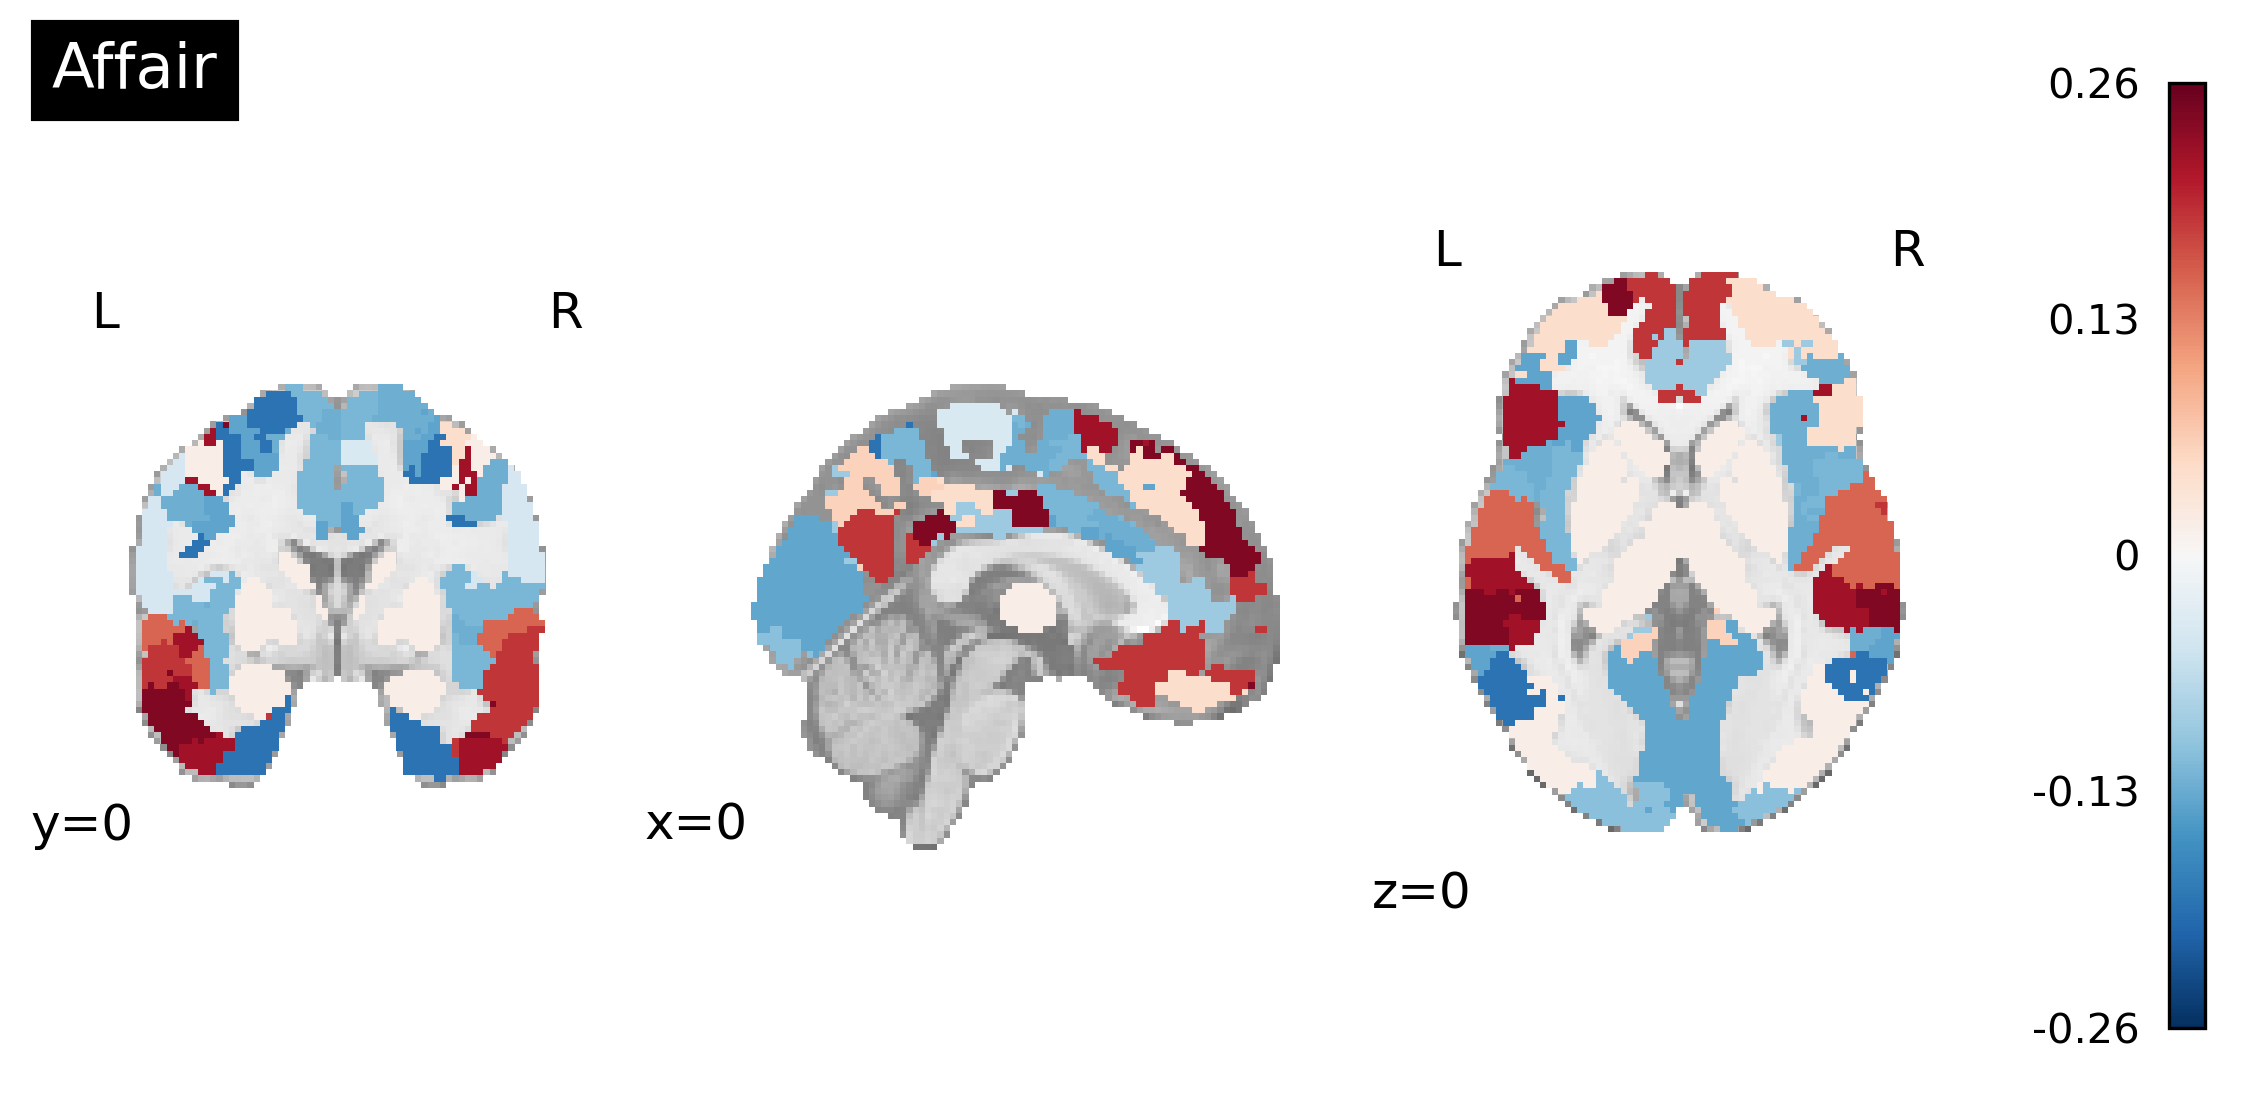

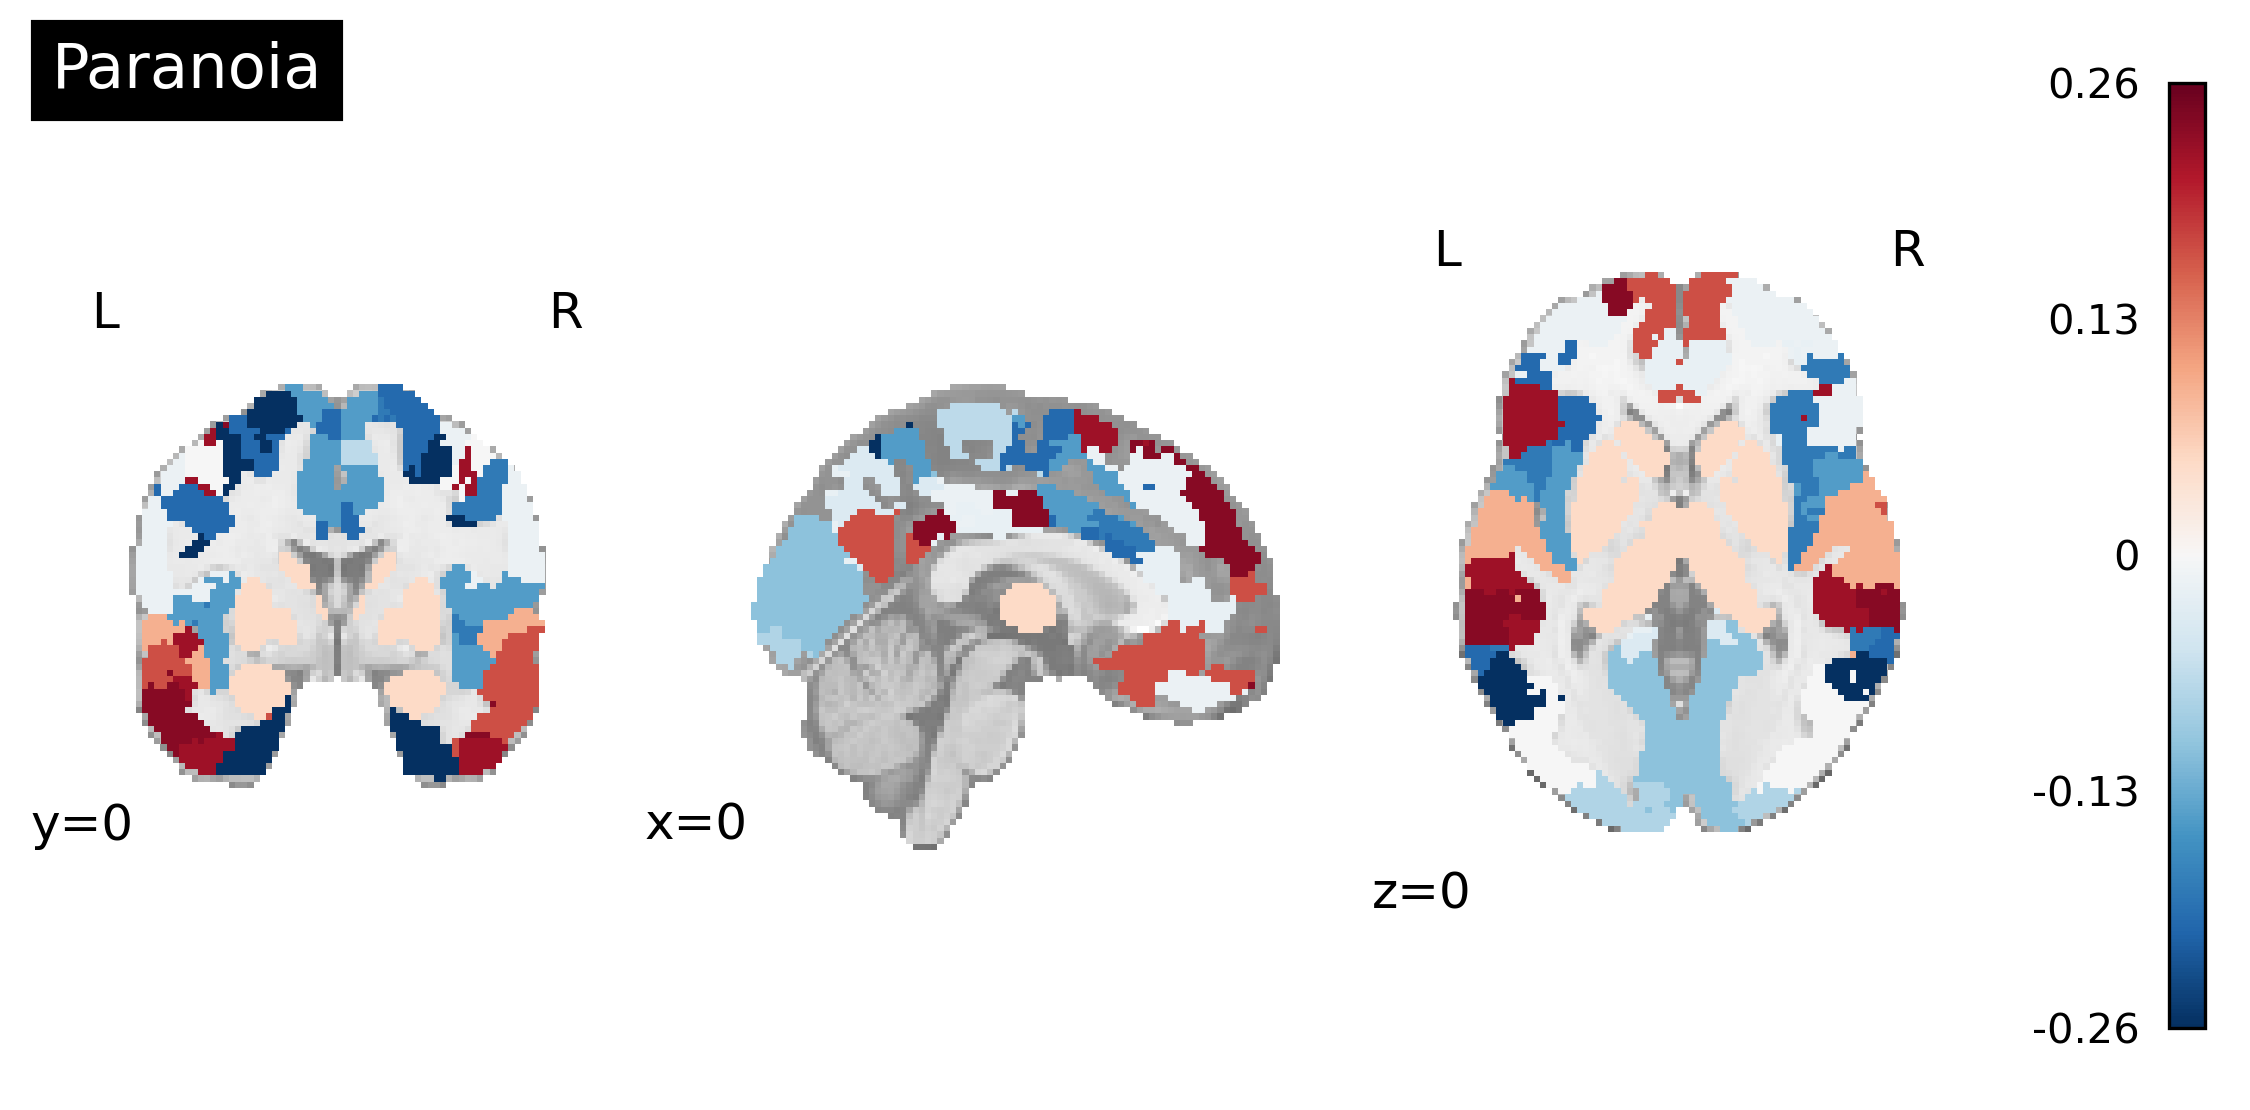

In [20]:
# Plot brain maps for state 1 (index 0)
plot_brain_maps(
    affair_state_brain_maps,
    paranoia_state_brain_maps, 
    SAVE_DIR_FIG2,
    state_num=0,  # For state 1
    state_mapping=state_mapping,
    display_mode=['ortho'],
    cut_coords=(0, 0, 0),
    vmax=0.26
)

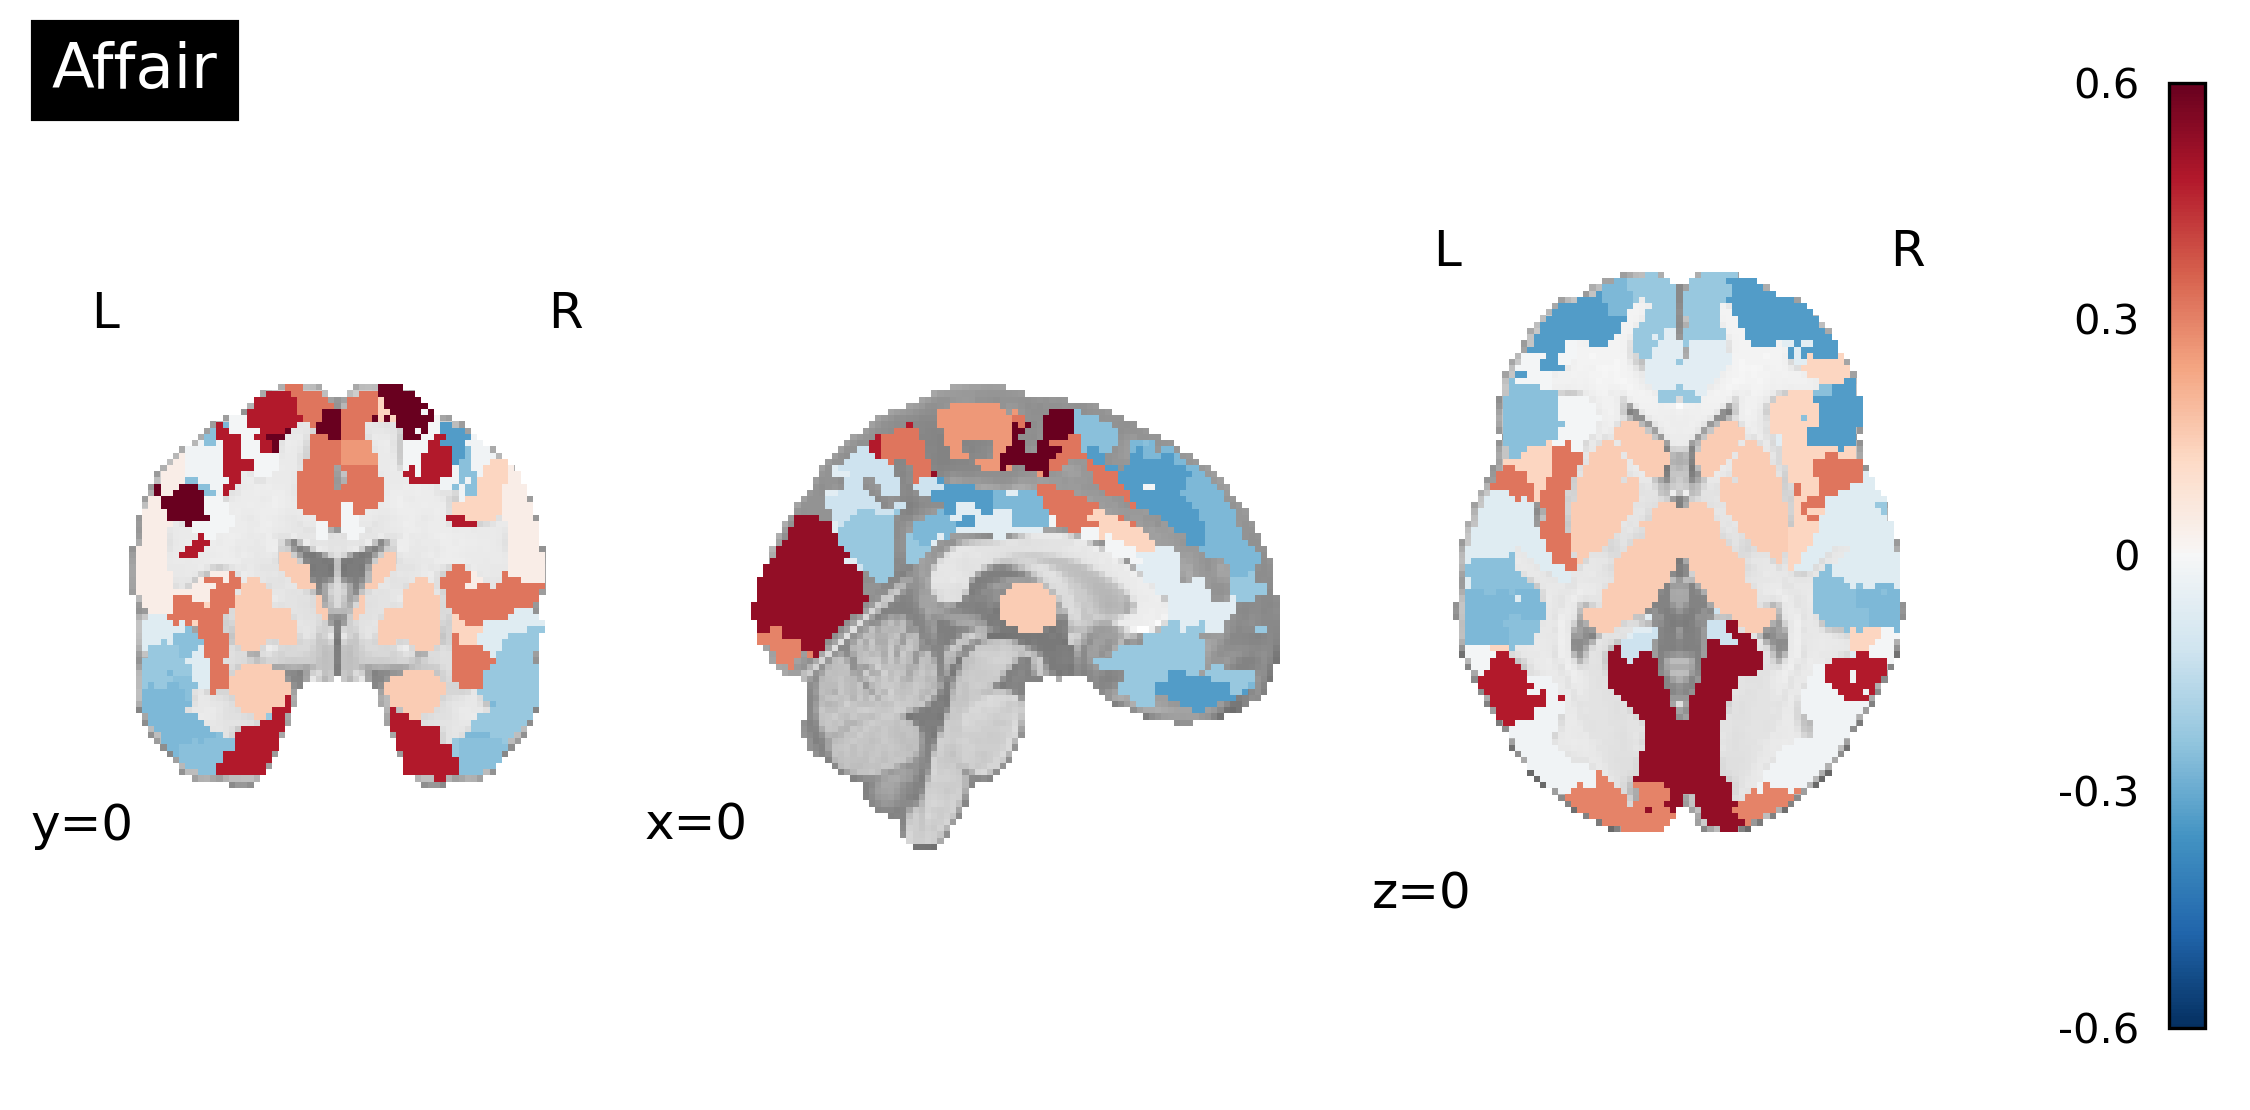

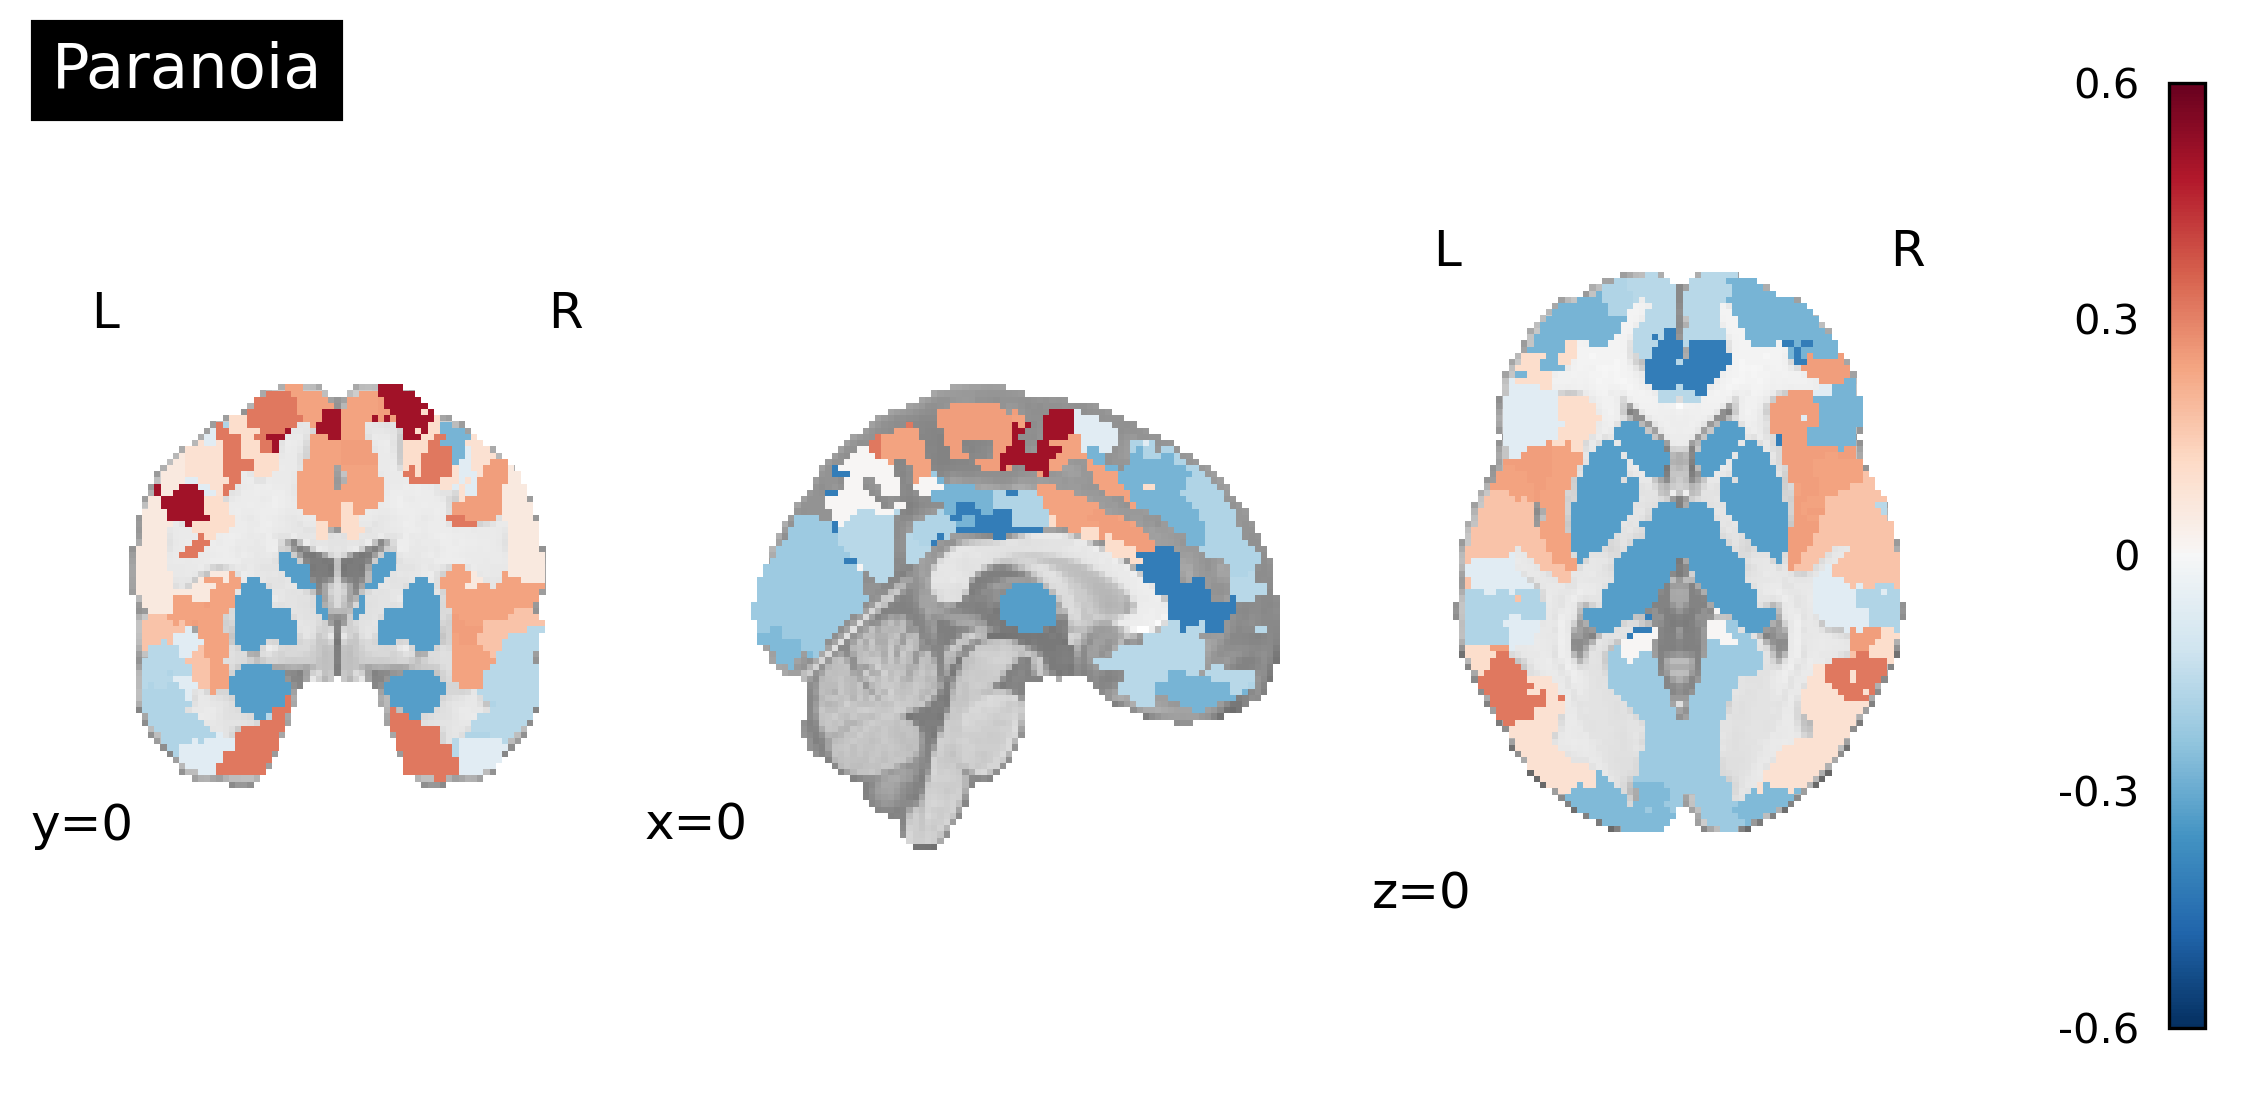

In [21]:
# Plot brain maps for state 1 (index 0)
plot_brain_maps(
    affair_state_brain_maps,
    paranoia_state_brain_maps, 
    SAVE_DIR_FIG2,
    state_num=1,  # For state 1
    state_mapping=state_mapping,
    display_mode=['ortho'],
    cut_coords=(0, 0, 0),
    vmax=0.6
)

In [23]:
# plot_brain_maps(affair_state_brain_maps, SAVE_DIR_FIG2, prefix='affair_state')

In [24]:
# plot_brain_maps(affair_state_brain_maps, SAVE_DIR_FIG2, prefix='affair_state', display_mode=['x', 'y', 'z'], cut_coords=5)

In [25]:
# plot_brain_maps(paranoia_state_brain_maps, SAVE_DIR_FIG2, prefix='paranoia_state')

In [26]:
# plot_brain_maps(paranoia_state_brain_maps, SAVE_DIR_FIG2, prefix='paranoia_state', display_mode=['x', 'y', 'z'], cut_coords=5)

In [27]:
def plot_paired_state_patterns(affair_properties: Dict, 
                             paranoia_properties: Dict,
                             state_mapping: Dict,
                             state_num: int,  # Add state number parameter
                             **kwargs) -> None:
    """Plot paired state patterns for a single state."""
    try:
        network_labels = ['Auditory', 'ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB',
                         'DefaultC', 'DorsAttnA', 'DorsAttnB', 'Language', 'SalVenAttnA',
                         'SalVenAttnB', 'SomMotA', 'SomMotB', 'VisualA', 'VisualB',
                         'VisualC', 'Subcortex']
        
        # Create figure with single subplot
        fig, ax = plt.subplots(figsize=(25, 5))
        
        # Get corresponding states
        affair_props = affair_properties[state_num]
        paranoia_state = state_mapping['affair_to_paranoia'][state_num]
        paranoia_props = paranoia_properties[paranoia_state]
        
        x = np.arange(len(network_labels))
        
        # Plot affair group
        ax.plot(x, affair_props['mean_pattern'], 'o-',
               color=COLORS['affair'],
               label='Affair',
               linewidth=2,
               markersize=6)
        
        if 'mean_pattern_ci' in affair_props:
            ci = affair_props['mean_pattern_ci']
            ax.fill_between(x, ci['lower'], ci['upper'],
                          color=COLORS['affair_light'],
                          alpha=0.4)
        
        # Plot paranoia group
        ax.plot(x, paranoia_props['mean_pattern'], 'o-',
               color=COLORS['paranoia'],
               label='Paranoia',
               linewidth=2,
               markersize=6)
        
        if 'mean_pattern_ci' in paranoia_props:
            ci = paranoia_props['mean_pattern_ci']
            ax.fill_between(x, ci['lower'], ci['upper'],
                          color=COLORS['paranoia_light'],
                          alpha=0.4)
        
        # Add title and labels
        ax.set_title(f'State {state_num+1}', fontsize=20)
        ax.set_ylabel('Activation', fontsize=18)
        
        # Set axis labels and ticks
        ax.set_xticks(x)
        ax.set_xticklabels(network_labels)
        ax.tick_params(axis='both', labelsize=14)
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=16)
        
        plt.tight_layout()
        plt.show()
        save_figure(fig, SAVE_DIR_FIG2, f"paired_state_{state_num+1}_patterns")
        
    except Exception as e:
        print(f"Error plotting paired state patterns: {e}")
        raise

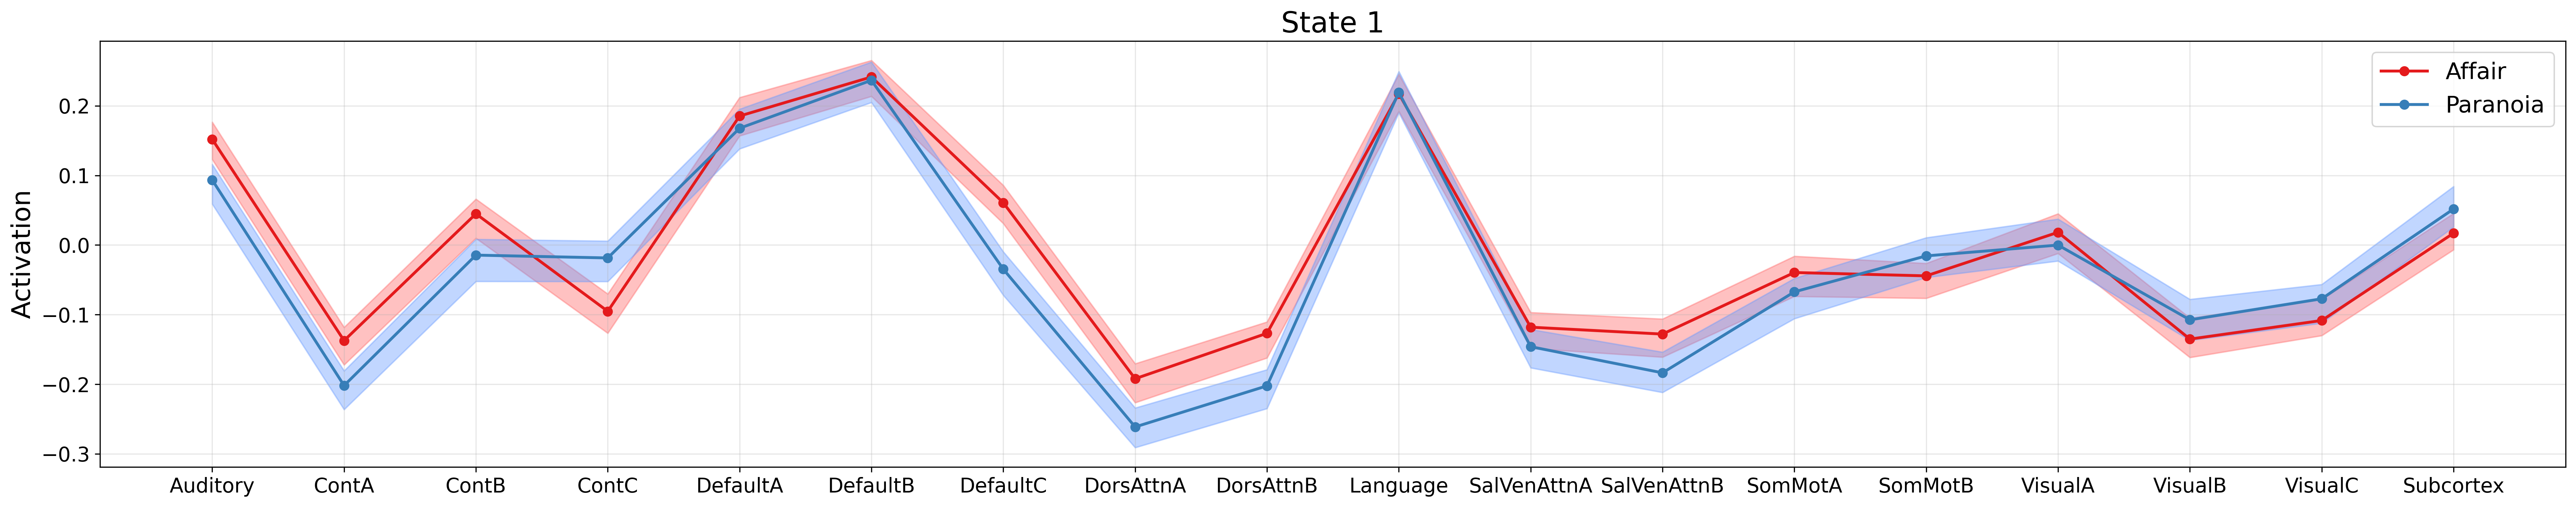

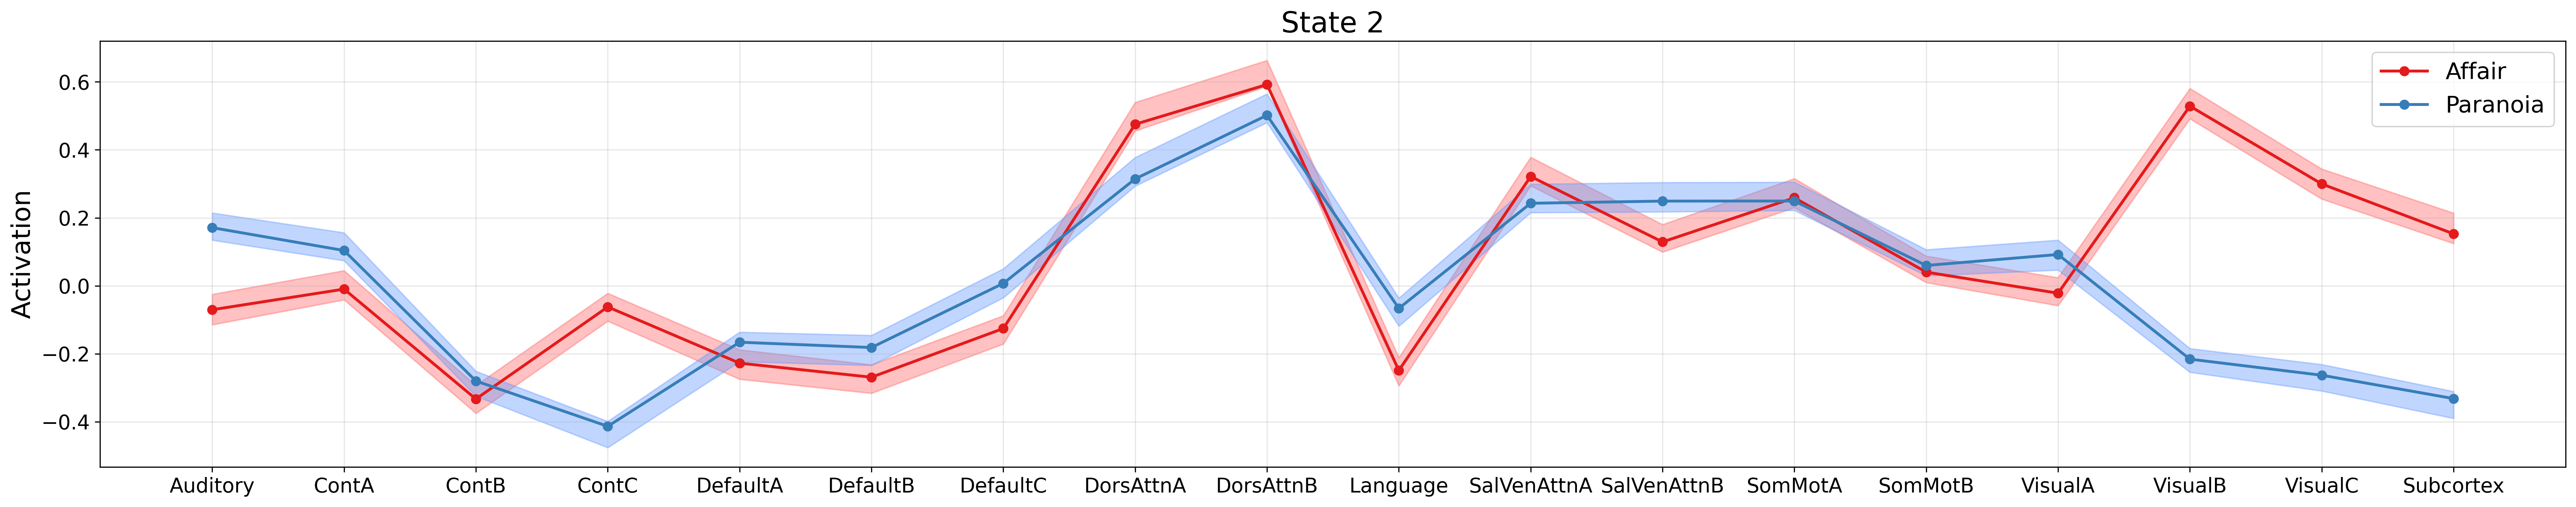

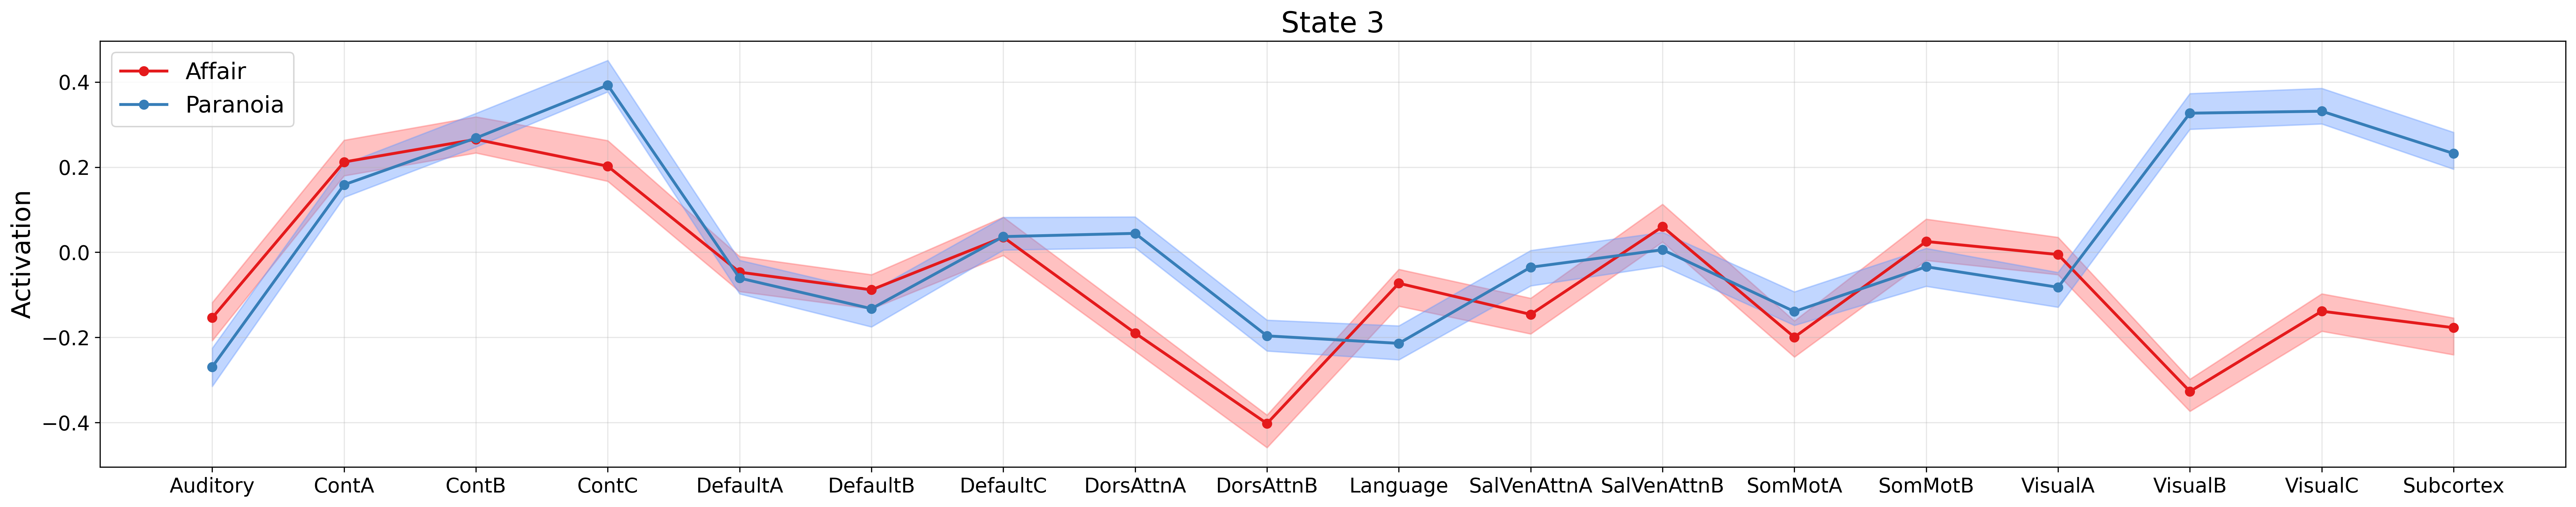

In [28]:
# Plot each state pair separately
for state in range(n_states):
    plot_paired_state_patterns(
        affair_result['metrics']['state_properties'],
        paranoia_result['metrics']['state_properties'],
        state_mapping,
        state_num=state
    )

In [10]:
affair_result['metrics']['state_metrics'].keys()

dict_keys(['subject_level', 'group_level', 'temporal', 'uncertainty'])

In [18]:
affair_result['metrics']['state_metrics']['group_level'].keys()

dict_keys(['durations', 'transitions', 'frequencies', 'fractional_occupancy', 'frequencies_ci', 'fractional_occupancy_ci', 'transition_entropy'])

In [20]:
affair_result['metrics']['state_metrics']['group_level']['fractional_occupancy']

array([0.434123  , 0.28323025, 0.28264675])

In [11]:
affair_result['metrics']['state_metrics']['subject_level'][0].keys()

dict_keys(['durations', 'transitions', 'frequencies', 'fractional_occupancy', 'duration_stats'])

In [12]:
affair_result['metrics']['state_metrics']['temporal'].keys()

dict_keys(['switching_rate', 'state_mixing', 'recurrence_intervals', 'state_stability', 'entropy_rate', 'summary', 'raw'])

In [33]:
affair_result['metrics']['state_metrics']['temporal']['raw']['switching_rates']

array([0.13451589, 0.09016999, 0.07834442, 0.10643016, 0.10347376,
       0.09903917, 0.07538803, 0.10051737, 0.07095344, 0.12121212,
       0.09756098, 0.0872136 , 0.10790835, 0.10347376, 0.10643016,
       0.11234294, 0.07834442, 0.0872136 , 0.07538803])

In [34]:
paranoia_result['metrics']['state_metrics']['temporal']['raw']['switching_rates']

array([0.10495196, 0.10495196, 0.10643016, 0.0886918 , 0.08130081,
       0.09903917, 0.09460458, 0.10495196, 0.11234294, 0.05764967,
       0.11677753, 0.0872136 , 0.10199557, 0.10199557, 0.10790835,
       0.10051737, 0.10495196, 0.11234294, 0.08277901])

In [13]:
affair_result['metrics']['state_metrics']['uncertainty'].keys()

dict_keys(['state_occupancy', 'transition_rates', 'temporal_metrics'])

In [14]:
affair_result['metrics']['state_metrics']['uncertainty']['state_occupancy'][0].keys()

dict_keys(['ci_lower', 'ci_upper', 'std'])

In [15]:
affair_result['metrics']['state_properties'].keys()

dict_keys([0, 1, 2, 'separability'])

In [16]:
affair_result['metrics']['state_properties'][0].keys()

dict_keys(['mean_pattern', 'mean_pattern_ci', 'std_pattern', 'cv_pattern', 'covariance', 'correlation', 'effective_dimension', 'feature_importance', 'top_features', 'pattern_stability'])

In [17]:
affair_result['metrics']['state_properties']['separability'].keys()

dict_keys(['pairwise_distances', 'confusion_matrix', 'mahalanobis_distances', 'bootstrap_metrics', 'summary'])

In [54]:
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},  # affair state 0 maps to paranoia state 1, etc.
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}   # paranoia state 1 maps to affair state 0, etc.
}

In [57]:
def compare_state_temporal_dynamics(affair_data, paranoia_data, state_mapping):
    """Compare temporal dynamics of aligned states between groups."""
    results = {}
    
    # Duration statistics comparison
    for affair_state, paranoia_state in state_mapping['affair_to_paranoia'].items():
        # Collect durations for each subject in each group
        affair_durations = [subj['duration_stats'][affair_state]['mean'] 
                           for subj in affair_data['subject_level'].values()]
        paranoia_durations = [subj['duration_stats'][paranoia_state]['mean'] 
                             for subj in paranoia_data['subject_level'].values()]
        
        # Statistical test
        t_stat, p_value = stats.ttest_ind(affair_durations, paranoia_durations)
        
        # Calculate effect size (Cohen's d)
        effect_size = (np.mean(paranoia_durations) - np.mean(affair_durations)) / \
                     np.sqrt((np.std(paranoia_durations)**2 + np.std(affair_durations)**2) / 2)
        
        results[f'state_{affair_state}_vs_{paranoia_state}'] = {
            'affair_mean_duration': np.mean(affair_durations),
            'paranoia_mean_duration': np.mean(paranoia_durations),
            'p_value': p_value,
            'effect_size': effect_size
        }
    
    return results

In [62]:
temporal_results = compare_state_temporal_dynamics(affair_result['metrics']['state_metrics'], paranoia_result['metrics']['state_metrics'], state_mapping)
temporal_results

{'state_0_vs_1': {'affair_mean_duration': 11.937386573477127,
  'paranoia_mean_duration': 11.306402650375679,
  'p_value': 0.7083877942290828,
  'effect_size': -0.12566624034807988},
 'state_1_vs_2': {'affair_mean_duration': 9.069103707497838,
  'paranoia_mean_duration': 8.187279324150428,
  'p_value': 0.06454675033011979,
  'effect_size': -0.6356130020496726},
 'state_2_vs_0': {'affair_mean_duration': 9.406109066102157,
  'paranoia_mean_duration': 10.163984441900576,
  'p_value': 0.31602083042620616,
  'effect_size': 0.3389425216441241}}

In [63]:
def compare_state_patterns(affair_states, paranoia_states, state_mapping):
    """Compare neural patterns of aligned states between groups."""
    results = {}
    
    for affair_state, paranoia_state in state_mapping['affair_to_paranoia'].items():
        # Get state patterns
        affair_pattern = affair_states[affair_state]['mean_pattern']
        paranoia_pattern = paranoia_states[paranoia_state]['mean_pattern']
        
        # Calculate similarity
        pattern_corr = np.corrcoef(affair_pattern, paranoia_pattern)[0, 1]
        
        # Compare feature importance
        affair_features = affair_states[affair_state]['top_features']['indices']
        paranoia_features = paranoia_states[paranoia_state]['top_features']['indices']
        shared_features = set(affair_features).intersection(set(paranoia_features))
        
        results[f'state_{affair_state}_vs_{paranoia_state}'] = {
            'pattern_correlation': pattern_corr,
            'affair_dimension': affair_states[affair_state]['effective_dimension'],
            'paranoia_dimension': paranoia_states[paranoia_state]['effective_dimension'],
            'shared_important_features': len(shared_features),
            'affair_stability': affair_states[affair_state]['pattern_stability'],
            'paranoia_stability': paranoia_states[paranoia_state]['pattern_stability']
        }
    
    return results

In [64]:
pattern_results = compare_state_patterns(affair_result['metrics']['state_properties'], paranoia_result['metrics']['state_properties'], state_mapping)
pattern_results

{'state_0_vs_1': {'pattern_correlation': 0.9451349704767232,
  'affair_dimension': 3.5097216681838495,
  'paranoia_dimension': 3.634608579670044,
  'shared_important_features': 10,
  'affair_stability': 0.9781190529234535,
  'paranoia_stability': 0.9897357407406784},
 'state_1_vs_2': {'pattern_correlation': 0.46798008803648633,
  'affair_dimension': 5.104726977346941,
  'paranoia_dimension': 5.029674821163042,
  'shared_important_features': 7,
  'affair_stability': 0.9726470864932794,
  'paranoia_stability': 0.9766442608990831},
 'state_2_vs_0': {'pattern_correlation': 0.33331942206505116,
  'affair_dimension': 4.595835500805606,
  'paranoia_dimension': 6.282833602307736,
  'shared_important_features': 8,
  'affair_stability': 0.9689666069538728,
  'paranoia_stability': 0.9185088407979235}}

In [65]:
def compare_transition_dynamics(affair_data, paranoia_data, state_mapping):
    """Compare state transition patterns between groups."""
    results = {}
    
    # Calculate average transition matrices for each group
    affair_transitions = np.mean([subj['transitions'] for subj in affair_data['subject_level'].values()], axis=0)
    paranoia_transitions = np.mean([subj['transitions'] for subj in paranoia_data['subject_level'].values()], axis=0)
    
    # Align paranoia transitions to affair state order
    paranoia_aligned = np.zeros_like(paranoia_transitions)
    for i in range(3):
        for j in range(3):
            paranoia_i = state_mapping['affair_to_paranoia'][i]
            paranoia_j = state_mapping['affair_to_paranoia'][j]
            paranoia_aligned[i, j] = paranoia_transitions[paranoia_i, paranoia_j]
    
    # Calculate transition differences
    transition_diff = paranoia_aligned - affair_transitions
    
    # Calculate transition entropy for each state
    affair_entropy = [-np.sum(affair_transitions[i] * np.log(affair_transitions[i] + 1e-10)) 
                     for i in range(3)]
    paranoia_entropy = [-np.sum(paranoia_aligned[i] * np.log(paranoia_aligned[i] + 1e-10)) 
                       for i in range(3)]
    
    results = {
        'affair_transitions': affair_transitions,
        'paranoia_aligned': paranoia_aligned,
        'transition_diff': transition_diff,
        'affair_entropy': affair_entropy,
        'paranoia_entropy': paranoia_entropy
    }
    
    return results

In [66]:
transition_results = compare_transition_dynamics(affair_result['metrics']['state_metrics'], paranoia_result['metrics']['state_metrics'], state_mapping)
transition_results
    


{'affair_transitions': array([[0.        , 0.59312083, 0.40687917],
        [0.56319933, 0.        , 0.43680067],
        [0.69559695, 0.30440305, 0.        ]]),
 'paranoia_aligned': array([[0.        , 0.54521115, 0.45478885],
        [0.61731935, 0.        , 0.38268065],
        [0.56960794, 0.43039206, 0.        ]]),
 'transition_diff': array([[ 0.        , -0.04790968,  0.04790968],
        [ 0.05412003,  0.        , -0.05412003],
        [-0.12598902,  0.12598902,  0.        ]]),
 'affair_entropy': [0.6757025247284174, 0.6851374621811666, 0.614548963601129],
 'paranoia_entropy': [0.6890534950467997,
  0.6653611956536445,
  0.6834251032629806]}

In [67]:
def compare_subject_consistency(affair_data, paranoia_data, state_mapping):
    """Compare how consistently states appear across subjects in each group."""
    # Extract fractional occupancy for each subject in each group
    affair_occupancy = np.array([list(subj['fractional_occupancy']) 
                               for subj in affair_data['subject_level'].values()])
    paranoia_occupancy = np.array([list(subj['fractional_occupancy']) 
                                 for subj in paranoia_data['subject_level'].values()])
    
    # Align paranoia occupancy to affair state order
    paranoia_aligned = np.zeros_like(paranoia_occupancy)
    for i in range(3):
        paranoia_i = state_mapping['affair_to_paranoia'][i]
        paranoia_aligned[:, i] = paranoia_occupancy[:, paranoia_i]
    
    # Calculate variance across subjects for each state
    affair_variance = np.var(affair_occupancy, axis=0)
    paranoia_variance = np.var(paranoia_aligned, axis=0)
    
    # Calculate average pairwise correlation between subjects
    affair_correlations = []
    paranoia_correlations = []
    
    for i in range(len(affair_occupancy)):
        for j in range(i+1, len(affair_occupancy)):
            affair_correlations.append(np.corrcoef(affair_occupancy[i], affair_occupancy[j])[0, 1])
    
    for i in range(len(paranoia_aligned)):
        for j in range(i+1, len(paranoia_aligned)):
            paranoia_correlations.append(np.corrcoef(paranoia_aligned[i], paranoia_aligned[j])[0, 1])
    
    return {
        'affair_state_variance': affair_variance,
        'paranoia_state_variance': paranoia_variance,
        'affair_subject_correlation': np.mean(affair_correlations),
        'paranoia_subject_correlation': np.mean(paranoia_correlations)
    }

In [69]:
consistency_results = compare_subject_consistency(affair_result['metrics']['state_metrics'], paranoia_result['metrics']['state_metrics'], state_mapping)
consistency_results

{'affair_state_variance': array([0.0236078 , 0.00456026, 0.0123093 ]),
 'paranoia_state_variance': array([0.02859393, 0.00479595, 0.01243271]),
 'affair_subject_correlation': 0.1872488137562338,
 'paranoia_subject_correlation': 0.10842534819789874}

In [1]:
from surfplot import Plot


In [2]:
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

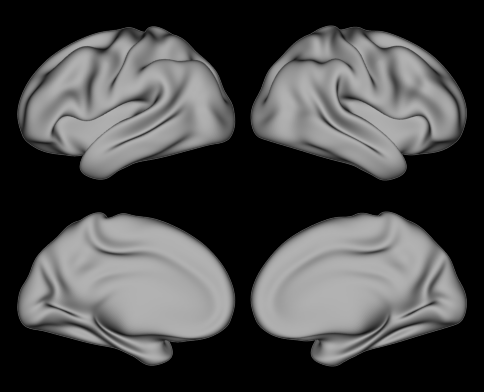

In [3]:
p = Plot(surf_lh=lh, surf_rh=rh)
fig = p.build()
# show figure, as you typically would with matplotlib
fig.show()

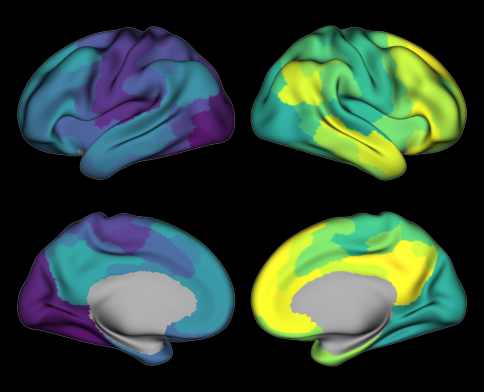

In [4]:
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation('schaefer')
p.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=False)

fig = p.build()
fig.show()